<a href="https://colab.research.google.com/github/roshinisanikop/Mitigating_Bias_in_Facial_Recognition_using_Seldonian_Framework/blob/main/BaselineModelTwo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 # This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
 # !git clone https://github.com/roshinisanikop/Mitigating_Bias_in_Facial_Recognition_using_Seldonian_Framework.git

In [ ]:
# TODO: Enter the foldername in your Drive where you have saved the unzipped

FOLDERNAME = '682_Project'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/Shared Drive/{}'.format(FOLDERNAME))


In [ ]:
!pip3 install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.5.0+cu121
torchvision version: 0.20.0+cu121


In [ ]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


In [ ]:
from datasets import load_dataset

ds = load_dataset("HuggingFaceM4/FairFace", "0.25")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.89k [00:00<?, ?B/s]

(…)-00000-of-00002-d405faba4f4b9b85.parquet:   0%|          | 0.00/250M [00:00<?, ?B/s]

(…)-00001-of-00002-dd3cb68164727418.parquet:   0%|          | 0.00/250M [00:00<?, ?B/s]

(…)-00000-of-00001-951dbd63c8724ee1.parquet:   0%|          | 0.00/63.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/86744 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10954 [00:00<?, ? examples/s]

In [ ]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['image', 'age', 'gender', 'race', 'service_test'],
        num_rows: 86744
    })
    validation: Dataset({
        features: ['image', 'age', 'gender', 'race', 'service_test'],
        num_rows: 10954
    })
})


In [ ]:
from collections import Counter

# race_counts_train = Counter(ds['train']['race'])
race_counts_train = Counter(ds['train']['race'])
print(race_counts_train)

min_race_count = min(race_counts_train.values())
print(f'Minimum samples per race: {min_race_count}')

Counter({3: 16527, 5: 13367, 1: 12319, 0: 12287, 2: 12233, 6: 10795, 4: 9216})
Minimum samples per race: 9216


In [ ]:
print((0.20 * 86744)/7)

2478.4


In [ ]:
ds_split = ds['train'].train_test_split(test_size=0.2, seed=42)

In [ ]:
print(ds_split)

DatasetDict({
    train: Dataset({
        features: ['image', 'age', 'gender', 'race', 'service_test'],
        num_rows: 69395
    })
    test: Dataset({
        features: ['image', 'age', 'gender', 'race', 'service_test'],
        num_rows: 17349
    })
})


In [ ]:
train_data = ds_split['train']
test_data = ds_split['test']
val_data = ds['validation']

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from datasets import load_dataset
from sklearn.model_selection import train_test_split

dtype = torch.float32

# Custom dataset class
class FairFaceDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        age = self.dataset[idx]['age']
        gender = self.dataset[idx]['gender']
        race = self.dataset[idx]['race']

        if self.transform:
            image = self.transform(image)

        # Add logging for debugging
        # print(f"Loading image {idx}: age={age}, gender={gender}, race={race}")

        return image, age, gender, race

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to desired dimensions
    transforms.ToTensor(),            # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.485, 0.485], std=[0.229, 0.229, 0.229])  # Normalize
])


In [ ]:
# Assuming the 'val_data' comes directly from the dataset, we can use that as is.
train_dataset = FairFaceDataset(train_data, transform=transform)
val_dataset = FairFaceDataset(val_data, transform=transform)
test_dataset = FairFaceDataset(test_data, transform=transform)

In [ ]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
#test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Check the sizes of the datasets
print(f"Training set size: {len(train_loader.dataset)}")
print(f"Validation set size: {len(val_loader.dataset)}")
#print(f"Test set size: {len(test_loader.dataset)}")

Training set size: 69395
Validation set size: 10954


## Create the model

In [ ]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

# Define the number of age groups
num_age_groups = 9  # Adjust based on your dataset

# Load the model
def load_pretrained_model(num_classes):
    # Load a pre-trained VGG-16 model
    model = models.vgg16(weights=None)

    # Modify the last layer to fit the number of classes in your dataset
    model.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)
    return model

model = load_pretrained_model(num_age_groups)
model.to(device)

# Set up the optimizer and loss function
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_criterion1 = nn.CrossEntropyLoss()

## Training and Validation loop

In [ ]:
import torch.nn.functional as F

def check_accuracy_part34(loader, model, is_validation = True):
    if is_validation:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode

    with torch.no_grad():
        for x, y, _, _ in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum().item()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

    return acc

In [ ]:
def plot_accuracies_batch(val_accs):
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Batch size')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Validation Accuracy over Increasing batch sizes')
    plt.show()

In [ ]:
def plot_accuracies_epoch(val_accs):
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Validation Accuracy over Epochs')
    plt.show()

In [ ]:
def train_part34(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.

    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for

    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    validation_acc_epoch = []
    val_batch = []

    for e in range(epochs):
      for t, (x, y,_,_) in enumerate(train_loader):

          model.train()  # put model to training mode


          x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
          y = y.to(device=device, dtype=torch.long)

          scores = model(x)
          loss = F.cross_entropy(scores, y)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          if t % print_every == 0:
              print('Iteration %d, loss = %.4f' % (t, loss.item()))
              val_accuracy = check_accuracy_part34(val_loader, model)
              val_batch.append(val_accuracy)
              print()

      val_acc = check_accuracy_part34(val_loader, model)
      validation_acc_epoch.append(val_acc)

    return val_batch, validation_acc_epoch

In [ ]:
val_batch, validation_acc_epoch = train_part34(model, optimizer, epochs=5)

Iteration 0, loss = 0.7425
Checking accuracy on validation set
Got 5485 / 10954 correct (50.07)

Iteration 100, loss = 0.5991
Checking accuracy on validation set
Got 5752 / 10954 correct (52.51)

Iteration 200, loss = 0.8268
Checking accuracy on validation set
Got 5888 / 10954 correct (53.75)

Iteration 300, loss = 0.5446
Checking accuracy on validation set
Got 5785 / 10954 correct (52.81)

Iteration 400, loss = 0.8598
Checking accuracy on validation set
Got 5781 / 10954 correct (52.78)

Iteration 500, loss = 0.4868
Checking accuracy on validation set
Got 5733 / 10954 correct (52.34)

Iteration 600, loss = 0.6581
Checking accuracy on validation set
Got 5768 / 10954 correct (52.66)

Iteration 700, loss = 0.4685
Checking accuracy on validation set
Got 5757 / 10954 correct (52.56)

Iteration 800, loss = 0.4669
Checking accuracy on validation set
Got 5636 / 10954 correct (51.45)

Iteration 900, loss = 0.4949
Checking accuracy on validation set
Got 5668 / 10954 correct (51.74)

Iteration 10

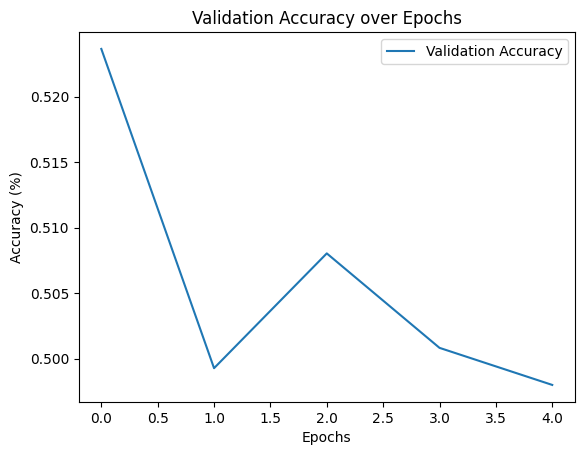

In [ ]:
plot_accuracies_epoch(validation_acc_epoch)

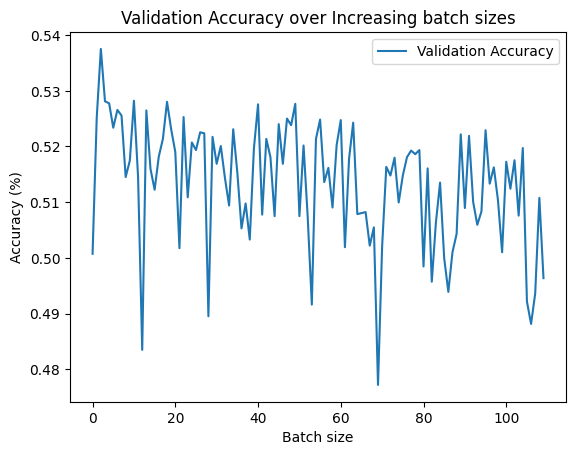

In [ ]:
plot_accuracies_batch(val_batch)

In [ ]:
def filter_dataset_by_race(dataset, race_value, sample_limit = 2000):

    filtered_data = [entry for entry in dataset if entry['race'] == race_value][:sample_limit]
    return filtered_data

In [ ]:
filtered_test_data_race3 = filter_dataset_by_race(test_data, race_value=3)
filtered_test_data_race5 = filter_dataset_by_race(test_data, race_value=5)

# Create a new dataset with only the filtered data
filtered_test_dataset_race3 = FairFaceDataset(filtered_test_data_race3, transform=transform)
filtered_test_dataset_race5 = FairFaceDataset(filtered_test_data_race5, transform=transform)

In [ ]:
test_loader_race3 = DataLoader(filtered_test_dataset_race3, batch_size=32, shuffle=False)
test_loader_race5 = DataLoader(filtered_test_dataset_race5, batch_size=32, shuffle=False)

In [ ]:
race3_acc = check_accuracy_part34(test_loader_race3, model, is_validation = False)
race5_acc = check_accuracy_part34(test_loader_race5, model, is_validation = False)

print("Accuracy of model on Caucasian race = ", race3_acc)
print("Accuracy of model on Hispanic / Latino race = ", race5_acc)

Checking accuracy on test set
Got 900 / 2000 correct (45.00)
Checking accuracy on test set
Got 981 / 2000 correct (49.05)
Accuracy of model on Caucasian race =  0.45
Accuracy of model on Hispanic / Latino race =  0.4905


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle
import torch

from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from itertools import cycle
import matplotlib.pyplot as plt
import torch
import numpy as np

def plot_confusion_matrix_and_roc(model, dataloader, classes):
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    y_true = []
    y_pred = []
    y_probs = []

    with torch.no_grad():
        for x, y, _, _ in dataloader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            probs = torch.softmax(scores, dim=1)
            _, preds = scores.max(1)

            num_correct += (preds == y).sum().item()
            num_samples += preds.size(0)

            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45)
    plt.show()

    # # ROC Curve
    # # Binarize the labels for multi-class ROC (one-vs-all)
    # y_test_bin = label_binarize(y_true, classes=range(len(classes)))
    # y_score = np.array(y_probs)  # Convert y_probs to NumPy array

    # fpr = dict()
    # tpr = dict()
    # roc_auc = dict()
    # n_classes = len(classes)

    # for i in range(n_classes):
    #     fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    #     roc_auc[i] = auc(fpr[i], tpr[i])

    # # Plot ROC curve for each class
    # plt.figure()
    # colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
    # for i, color in zip(range(n_classes), colors):
    #     plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {classes[i]}')

    # plt.plot([0, 1], [0, 1], 'k--', lw=2)
    # plt.xlim([0.0, 1.0])
    # plt.ylim([0.0, 1.05])
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.title('Receiver Operating Characteristic (ROC)')
    # plt.legend(loc="lower right")
    # plt.show()


In [ ]:
age_classes = ['0-2','3-9', '10-19', '20-29', '31-40', '41-50', '50-59', '60-69', 'more than 70']

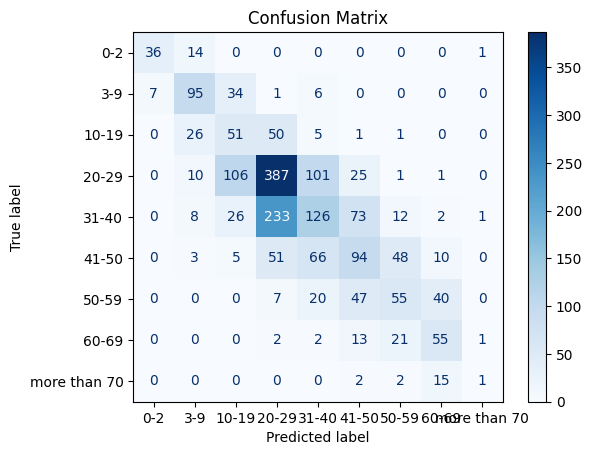

In [ ]:
plot_confusion_matrix_and_roc(model, test_loader_race3, age_classes)

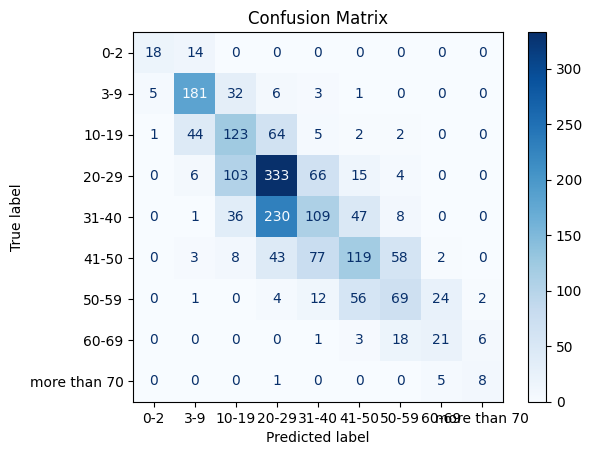

In [ ]:
plot_confusion_matrix_and_roc(model, test_loader_race5, age_classes)